In [10]:
# Make sure we are in the `deep-radar` directory.
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
print("cwd:", os.getcwd())

cwd: /home/tianshu/Documents/RadarML/deep-radar


In [2]:
import numpy as np

import analysis


def comparison_grid(
    axs: np.ndarray, compare: dict[str, analysis.ComparativeStats],
    method_names: list[str] = []
) -> None:
    """Plot grid of comparison plots."""
    for row, (category, stats) in zip(axs, compare.items()):
        stats = stats.sum()
        analysis.comparison_matrix(
            row[0], stats.percent(), unit="%", cmap='coolwarm')
        analysis.comparison_matrix(
            row[1],
            stats.significance(p=0.05, corrected=True, subgroups=len(compare))
            + stats.significance(p=0.05, corrected=False),
            label=stats.diff.zscore, unit=" se", cmap='coolwarm')
        analysis.comparison_matrix(
            row[2], stats.diff.ess.astype(np.int64), cmap="viridis", sig=0)
        analysis.comparison_matrix(
            row[3], stats.diff.stderr, cmap="viridis")

    for ax, category in zip(axs[:, 0], compare):
        ax.set_ylabel(category)
        ax.set_yticklabels(method_names)
    metric_names = [
        "percent difference", "z-score",
        "effective sample size", "standard error"]
    for ax, metric in zip(axs[-1], metric_names):
        ax.set_xlabel(metric)
        ax.set_xticklabels(method_names)

In [4]:
results = analysis.Results("results")
methods = ["unet/b.i", "unet/b.o", "unet/b.io"]
method_names = ["indoor", "outdoor", "joint"]
compare = {
    "indoor": results.compare(methods, key="bev_loss", pattern="^indoor"),
    "outdoor": results.compare(methods, key="bev_loss", pattern="^outdoor")
}

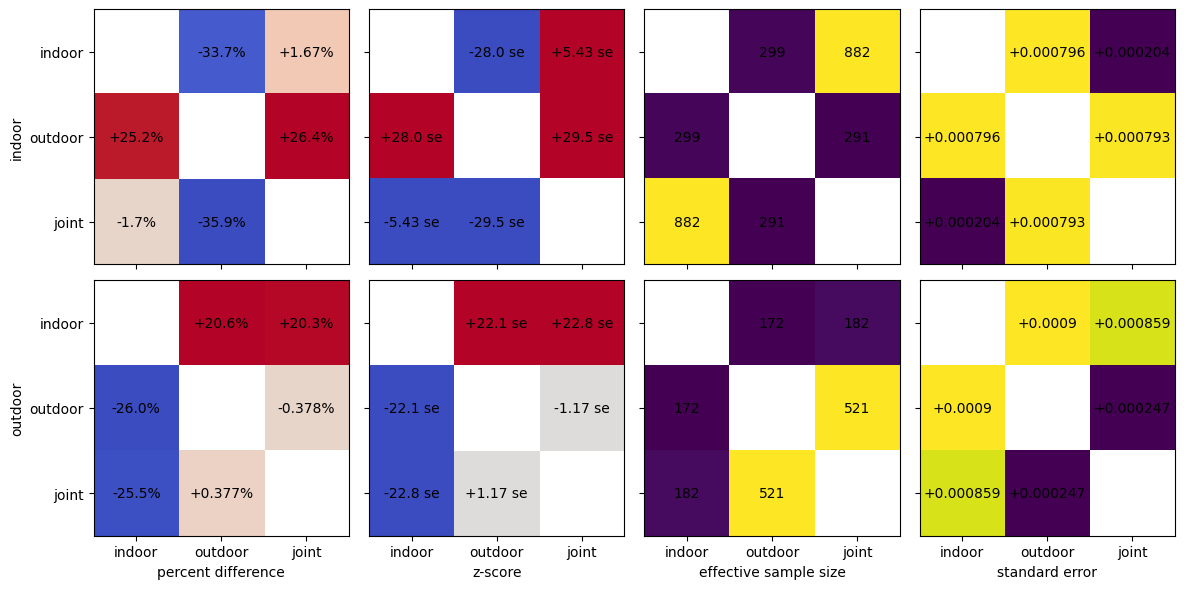

In [5]:
from matplotlib import pyplot as plt

size = 1.0 * len(methods)
fig, axs = plt.subplots(
    len(compare), 4, figsize=(size * 4, size * len(compare)))
comparison_grid(axs, compare, method_names)
fig.tight_layout()